<a href="https://colab.research.google.com/github/zeynepervayalindag/taxi_environment/blob/main/taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**OpenAI Gym Taxi environment**

In [87]:
!pip install gym==0.26.2
!pip install numpy==1.26.4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 15.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827727 sha256=e615a630fd659c41359ee0925de32faa0ad0f4fe6d1dcd1c1880dcdf6254c1a4
  Stored in directory: /root/.cache/pip/wheels/95/51/6c/9bb05ebbe7c5cb8171dfaa3611f32622ca4658d53f31c79077
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [32]:
from contextlib import closing
from io import StringIO
from os import path
from typing import Optional

import numpy as np

from gymnasium import Env, logger, spaces, utils  # Ortam yapısı ve loglama
from gymnasium.envs.toy_text.utils import categorical_sample # Olasılıklı seçim (stochastic reset için)
from gymnasium.error import DependencyNotInstalled # Pygame eksik hatası

from gymnasium.envs.registration import register

MAP = [
    "-------------",
    "|O: |X: : :G|",
    "| : | | : : |",
    "|X: |P: : : |",
    "| | : | : : |",
    "|Y|X: |B| : |",
    "| | : | :X: |",
    "-------------",
]
WINDOW_SIZE = (550, 350)


class TaxiEnv(Env):
    """

    The Taxi Problem
    from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich

    ### Description
    There are four designated locations in the grid world indicated by R(ed),
    G(reen), Y(ellow), B(lue) and P(ink). When the episode starts, the taxi starts off
    at a random square and the passenger is at a random location. The taxi
    drives to the passenger's location, picks up the passenger, drives to the
    passenger's destination (another one of the four specified locations), and
    then drops off the passenger. Once the passenger is dropped off, the episode ends.

    Map:

        -------------
        |O: |X: : :G|
        | : | | : : |
        |X: |P: : : |
        | | : | : : |
        |Y|X: |B| : |
        | | : | :X: |
        -------------

    ### Actions
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger

    ### Observations
    There are 1080 discrete states since there are 36 taxi positions, 6 possible
    locations of the passenger (including the case when the passenger is in the
    taxi), and  5 destination locations.

    Note that there are 900 states that can actually be reached during an
    episode. The missing states correspond to situations in which the passenger
    is at the same location as their destination, as this typically signals the
    end of an episode. Four additional states can be observed right after a
    successful episodes, when both the passenger and the taxi are at the destination.
    This gives a total of 905 reachable discrete states.

    Each state space is represented by the tuple:
    (taxi_row, taxi_col, passenger_location, destination)

    An observation is an integer that encodes the corresponding state.
    The state tuple can then be decoded with the "decode" method.

    Passenger locations:
    - 0: O(range)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: P(urple)
    - 5: in taxi

    Destinations:
    - 0: O(range)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: P(urple)

    ### Info

    ``step`` and ``reset()`` will return an info dictionary that contains "p" and "action_mask" containing
        the probability that the state is taken and a mask of what actions will result in a change of state to speed up training.

    As Taxi's initial state is a stochastic, the "p" key represents the probability of the
    transition however this value is currently bugged being 1.0, this will be fixed soon.
    As the steps are deterministic, "p" represents the probability of the transition which is always 1.0

    For some cases, taking an action will have no effect on the state of the agent.
    In v0.25.0, ``info["action_mask"]`` contains a np.ndarray for each of the action specifying
    if the action will change the state.

    To sample a modifying action, use ``action = env.action_space.sample(info["action_mask"])``
    Or with a Q-value based algorithm ``action = np.argmax(q_values[obs, np.where(info["action_mask"] == 1)[0]])``.

    ### Rewards
    - -1 per step unless other reward is triggered.
    - +20 delivering passenger.
    - -10  executing "pickup" and "drop-off" actions illegally.

    ### Arguments

    ```
    gym.make('Taxi-v3_by_Zeynep_Erva')
    ```
    ###
    There are also no-entry cells, so let's mark them in red. Passengers cannot wait in these cells, and vehicles cannot enter.

    ### Version History
    * v3: Map Correction + Cleaner Domain Description, v0.25.0 action masking added to the reset and step information
    * v2: Disallow Taxi start location = goal location, Update Taxi observations in the rollout, Update Taxi reward threshold.
    * v1: Remove (3,2) from locs, add passidx<4 check
    * v0: Initial versions release
    """

    metadata = {
        "render_modes": ["human", "ansi", "rgb_array"],
        "render_fps": 4, # Her saniyede max 4 frame
    }

    def __init__(self, render_mode: Optional[str] = None):
        self.desc = np.asarray(MAP, dtype="c")

        self.locs = locs = [(0,0), (0,5), (4,0), (4,3), (2,2)]
        self.locs_colors = [(255,140,0), (0,255,0), (255,255,0), (0,0,255), (115, 41, 130)]

        num_states = 1080
        num_rows = 6
        num_columns = 6
        max_row = num_rows - 1
        max_col = num_columns - 1
        self.initial_state_distrib = np.zeros(num_states)
        num_actions = 6
        # Yapısı: P[state][action] = [(probability, new_state, reward, done)]
        self.P = {
            state: {action: [] for action in range(num_actions)}
            for state in range(num_states)
        }
        self.no_entry_cells = [(2,0), (0,2), (4,1), (5,4)]
        for row in range(num_rows):
            for col in range(num_columns):
                for pass_idx in range(len(locs) + 1):  # Yolcu içeride ise +1
                    for dest_idx in range(len(locs)):
                      # Yani her (row, col, pass_idx) kombinasyonu için tüm hedefler değerlendir
                        state = self.encode(row, col, pass_idx, dest_idx)
                        # Mevcut (row, col, pass_idx, dest_idx) durumunu tek bir tamsayıya çevir.
                        if pass_idx < 5 and pass_idx != dest_idx :
                          # Eğer yolcu hâlâ yerdeyse (pass_idx < 5) ve yolcunun bulunduğu konum
# hedefle aynı değilse (yani yolcu daha önce teslim edilmiş değilse),
# bu başlangıç durumunu olasılık dağılımına ekle.
                            self.initial_state_distrib[state] += 1
                        for action in range(num_actions):
                            # defaults
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = (
                                -1
                            )  # default reward when there is no pickup/dropoff
                            terminated = False
                            taxi_loc = (row, col)

                            if action == 0:  # South
                                new_row = min(row + 1, max_row)
                                if (new_row, new_col) in self.no_entry_cells:
                                    new_row = row
                                    moved_to_no_entry = True

                            elif action == 1:  # North
                                new_row = max(row - 1, 0)
                                if (new_row, new_col) in self.no_entry_cells:
                                    new_row = row
                                    moved_to_no_entry = True

                            elif action == 2:  # East
                                if self.desc[1 + row, 2 * col + 2] == b":":
                                    new_col = min(col + 1, max_col)
                                    if (new_row, new_col) in self.no_entry_cells:
                                        new_col = col
                                        moved_to_no_entry = True
                                else:
                                    # Duvar varsa hareket etme
                                    new_col = col

                            elif action == 3:  # West
                                if self.desc[1 + row, 2 * col] == b":":
                                    new_col = max(col - 1, 0)
                                    if (new_row, new_col) in self.no_entry_cells:
                                        new_col = col
                                        moved_to_no_entry = True
                                else:
                                    # Duvar varsa hareket etme
                                    new_col = col


                            elif action == 4:  # pickup
                                if pass_idx < 5 and taxi_loc == locs[pass_idx]:
                                    new_pass_idx = 5
                                else:  # passenger not at location
                                    reward = -10
                            elif action == 5:  # dropoff
                                if (taxi_loc == locs[dest_idx]) and pass_idx == 5:
                                    new_pass_idx = dest_idx
                                    terminated = True
                                    reward = 20
                                elif (taxi_loc in locs) and pass_idx == 5:
                                    new_pass_idx = locs.index(taxi_loc)
                                else:  # dropoff at wrong location
                                    reward = -10
                            new_state = self.encode(
                                new_row, new_col, new_pass_idx, dest_idx
                            )
                            self.P[state][action].append(
                                (1.0, new_state, reward, terminated)
                            )
        self.initial_state_distrib /= self.initial_state_distrib.sum()
        self.action_space = spaces.Discrete(num_actions)
        self.observation_space = spaces.Discrete(num_states)

        self.render_mode = render_mode

        # pygame utils
        self.window = None
        self.clock = None
        self.cell_size = (
            WINDOW_SIZE[0] / self.desc.shape[1],
            WINDOW_SIZE[1] / self.desc.shape[0],
        )
        self.taxi_imgs = None
        self.taxi_orientation = 0
        self.passenger_img = None
        self.destination_img = None
        self.median_horiz = None
        self.median_vert = None
        self.background_img = None
        self.red = None

    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        # (6) 6, 6, 5
        i = taxi_row
        i *= 6
        i += taxi_col
        i *= 6
        i += pass_loc
        i *= 5
        i += dest_idx
        return i

    def decode(self, i):
        out = []
        out.append(i % 5)
        i = i // 5
        out.append(i % 6)
        i = i // 6
        out.append(i % 6)
        i = i // 6
        out.append(i)
        assert 0 <= i < 6
        return reversed(out)

    def action_mask(self, state: int):
        """Computes an action mask for the action space using the state information."""
        mask = np.zeros(6, dtype=np.int8)
        taxi_row, taxi_col, pass_loc, dest_idx = self.decode(state)
        # South action - aşağı hareket
        if taxi_row < 5 and (taxi_row + 1, taxi_col) not in self.no_entry_cells:
            mask[0] = 1

        # North action - yukarı hareket
        if taxi_row > 0 and (taxi_row - 1, taxi_col) not in self.no_entry_cells:
            mask[1] = 1

        # East action - sağa hareket
        if (taxi_col < 5 and
            self.desc[1 + taxi_row, 2 * taxi_col + 2] == b":" and
            (taxi_row, taxi_col + 1) not in self.no_entry_cells):
            mask[2] = 1

        # West action - sola hareket
        if (taxi_col > 0 and
            self.desc[1 + taxi_row, 2 * taxi_col] == b":" and
            (taxi_row, taxi_col - 1) not in self.no_entry_cells):
            mask[3] = 1

        # Pickup action
        if pass_loc < 5 and (taxi_row, taxi_col) == self.locs[pass_loc]:
            mask[4] = 1

        # Dropoff action
        if pass_loc == 5 and (
            (taxi_row, taxi_col) == self.locs[dest_idx]
            or (taxi_row, taxi_col) in self.locs
        ):
            mask[5] = 1

        return mask

    def step(self, a):
        transitions = self.P[self.s][a]
        # Bu state ve aksiyon için önceden hesaplanmış geçiş listesi alınır
        i = categorical_sample([t[0] for t in transitions], self.np_random)
        # Eğer geçişler olasılıklıysa (stochastic) hangi geçişin seçileceği belirlenir
        p, s, r, t = transitions[i]
        self.s = s
        self.lastaction = a

        if self.render_mode == "human":
            self.render()
        return (int(s), r, t, False, {"prob": p, "action_mask": self.action_mask(s)})

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.s = categorical_sample(self.initial_state_distrib, self.np_random)
        self.lastaction = None
        self.taxi_orientation = 0

        if self.render_mode == "human":
            self.render()
        return int(self.s), {"prob": 1.0, "action_mask": self.action_mask(self.s)}

    def render(self):
        if self.render_mode is None:
            logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
        if self.render_mode == "ansi":
            return self._render_text()
        else:  # self.render_mode in {"human", "rgb_array"}:
            return self._render_gui(self.render_mode)

    def _render_gui(self, mode):
        try:
            import pygame  # dependency to pygame only if rendering with human
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[toy_text]`"
            )

        if self.window is None:
            pygame.init()
            pygame.display.set_caption("Taxi")
            if mode == "human":
                self.window = pygame.display.set_mode(WINDOW_SIZE)
            elif mode == "rgb_array":
                self.window = pygame.Surface(WINDOW_SIZE)

        assert (
            self.window is not None
        ), "Something went wrong with pygame. This should never happen."
        if self.clock is None:
            self.clock = pygame.time.Clock()
        if self.taxi_imgs is None:
            file_names = [
                path.join("/content/drive/MyDrive/Colab_Notebooks_YL/derin_pekistirmeli_ogrenme_dersi/gym-master/gym/envs/toy_text/img/cab_front.png"),
                path.join("/content/drive/MyDrive/Colab_Notebooks_YL/derin_pekistirmeli_ogrenme_dersi/gym-master/gym/envs/toy_text/img/cab_rear.png"),
                path.join("/content/drive/MyDrive/Colab_Notebooks_YL/derin_pekistirmeli_ogrenme_dersi/gym-master/gym/envs/toy_text/img/cab_right.png"),
                path.join("/content/drive/MyDrive/Colab_Notebooks_YL/derin_pekistirmeli_ogrenme_dersi/gym-master/gym/envs/toy_text/img/cab_left.png"),
            ]
            self.taxi_imgs = [
                pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
                for file_name in file_names
            ]
        if self.red is None:
          file_name = path.join("/content/drive/MyDrive/Colab_Notebooks_YL/derin_pekistirmeli_ogrenme_dersi/gym-master/gym/envs/toy_text/img/red.png")
          self.red = pygame.transform.scale(pygame.image.load(file_name), self.cell_size)
        if self.passenger_img is None:
            file_name = path.join("/content/drive/MyDrive/Colab_Notebooks_YL/derin_pekistirmeli_ogrenme_dersi/gym-master/gym/envs/toy_text/img/passenger.png")
            self.passenger_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.destination_img is None:
            file_name = path.join("/content/drive/MyDrive/Colab_Notebooks_YL/derin_pekistirmeli_ogrenme_dersi/gym-master/gym/envs/toy_text/img/hotel.png")
            self.destination_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
            self.destination_img.set_alpha(170)
        if self.median_horiz is None:
            _wall_img_path = path.join("/content/drive/MyDrive/Colab_Notebooks_YL/derin_pekistirmeli_ogrenme_dersi/gym-master/gym/envs/toy_text/img/wall.png")
            single_wall_surface = pygame.transform.scale(pygame.image.load(_wall_img_path), self.cell_size)
            self.median_horiz = [single_wall_surface, single_wall_surface, single_wall_surface]

        if self.median_vert is None:
            _wall_img_path = path.join("/content/drive/MyDrive/Colab_Notebooks_YL/derin_pekistirmeli_ogrenme_dersi/gym-master/gym/envs/toy_text/img/wall.png")
            single_wall_surface = pygame.transform.scale(pygame.image.load(_wall_img_path), self.cell_size)
            self.median_vert = [single_wall_surface, single_wall_surface, single_wall_surface]

        if self.background_img is None:
            file_name = path.join("/content/drive/MyDrive/Colab_Notebooks_YL/derin_pekistirmeli_ogrenme_dersi/gym-master/gym/envs/toy_text/img/taxi_background.png")
            self.background_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )

        desc = self.desc

        for y in range(0, desc.shape[0]):
            for x in range(0, desc.shape[1]):
                cell = (x * self.cell_size[0], y * self.cell_size[1])
                self.window.blit(self.background_img, cell)
                if desc[y][x] == b"|" and (y == 0 or desc[y - 1][x] != b"|"):
                    self.window.blit(self.median_vert[0], cell)
                elif desc[y][x] == b"X":
                    self.window.blit(self.red, cell)
                elif desc[y][x] == b"|" and (
                    y == desc.shape[0] - 1 or desc[y + 1][x] != b"|"
                ):
                    self.window.blit(self.median_vert[2], cell)
                elif desc[y][x] == b"|":
                    self.window.blit(self.median_vert[1], cell)
                elif desc[y][x] == b"-" and (x == 0 or desc[y][x - 1] != b"-"):
                    self.window.blit(self.median_horiz[0], cell)
                elif desc[y][x] == b"-" and (
                    x == desc.shape[1] - 1 or desc[y][x + 1] != b"-"
                ):
                    self.window.blit(self.median_horiz[2], cell)
                elif desc[y][x] == b"-":
                    self.window.blit(self.median_horiz[1], cell)

        for cell, color in zip(self.locs, self.locs_colors):
            color_cell = pygame.Surface(self.cell_size)
            color_cell.set_alpha(128)
            color_cell.fill(color)
            loc = self.get_surf_loc(cell)
            self.window.blit(color_cell, (loc[0], loc[1] + 10))
        for r in range(self.desc.shape[0]):
          for c in range(self.desc.shape[1]):
            if self.desc[r, c] == b"X":
                surf_x = (c - 1) // 2
                surf_y = r - 1
                if 0 <= surf_x < 6 and 0 <= surf_y < 6:
                    red_cell = pygame.Surface(self.cell_size)
                    red_cell.set_alpha(180)
                    red_cell.fill((255, 0, 0))
                    loc = self.get_surf_loc((surf_y, surf_x))
                    self.window.blit(red_cell, (loc[0], loc[1] + 10))
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        if pass_idx < 5:
            self.window.blit(self.passenger_img, self.get_surf_loc(self.locs[pass_idx]))

        if self.lastaction in [0, 1, 2, 3]:
            self.taxi_orientation = self.lastaction
        dest_loc = self.get_surf_loc(self.locs[dest_idx])
        taxi_location = self.get_surf_loc((taxi_row, taxi_col))

        if dest_loc[1] <= taxi_location[1]:
            self.window.blit(
                self.destination_img,
                (dest_loc[0], dest_loc[1] - self.cell_size[1] // 2),
            )
            self.window.blit(self.taxi_imgs[self.taxi_orientation], taxi_location)
        else:  # change blit order for overlapping appearance
            self.window.blit(self.taxi_imgs[self.taxi_orientation], taxi_location)
            self.window.blit(
                self.destination_img,
                (dest_loc[0], dest_loc[1] - self.cell_size[1] // 2),
            )

        if mode == "human":
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        elif mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.window)), axes=(1, 0, 2)
            )

    def get_surf_loc(self, map_loc):
        return (map_loc[1] * 2 + 1) * self.cell_size[0], (
            map_loc[0] + 1
        ) * self.cell_size[1]

    def _render_text(self):
        desc = self.desc.copy().tolist()
        outfile = StringIO()

        out = [[c.decode("utf-8") for c in line] for line in desc]
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        def ul(x):
          # Eğer hücre boşsa '_' karakteriyle göster, aksi halde olduğu gibi döndür
            return "_" if x == " " else x

        if pass_idx < 5:
          # Yolcu yerdeyse taksinin bulunduğu hücreyi sarı ile vurgula
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                out[1 + taxi_row][2 * taxi_col + 1], "yellow", highlight=True
            )
            # Yolcunun bulunduğu lokasyonu mavi ve kalın göster
            pi, pj = self.locs[pass_idx]
            out[1 + pi][2 * pj + 1] = utils.colorize(
                out[1 + pi][2 * pj + 1], "blue", bold=True
            )
        else:  # Yolcu taksideyse taksinin içindeki sembolü yeşil ile göster
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                ul(out[1 + taxi_row][2 * taxi_col + 1]), "green", highlight=True
            )
        # Hedef lokasyonu magenta ile göster
        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = utils.colorize(out[1 + di][2 * dj + 1], "magenta")
        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write(
                f"  ({['South', 'North', 'East', 'West', 'Pickup', 'Dropoff'][self.lastaction]})\n"
            )
        else:
            outfile.write("\n")

        with closing(outfile):
            return outfile.getvalue()

    def close(self):
        if self.window is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()

# Ortamı Gym’e kaydet
register(
    id="Taxi-v3_by_Zeynep_Erva",            # İstediėin isim
    entry_point=__name__ + ":TaxiEnv",  # Şıu dosyadaki TaxiEnv sınıfını göster
)


# Taxi rider from https://franuka.itch.io/rpg-asset-pack
# All other assets by Mel Tillery http://www.cyaneus.com/

/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:636: UserWarning: WARN: Overriding environment Taxi-v3_by_Zeynep_Erva already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


**Save OpenAI Gym renders as GIFS**

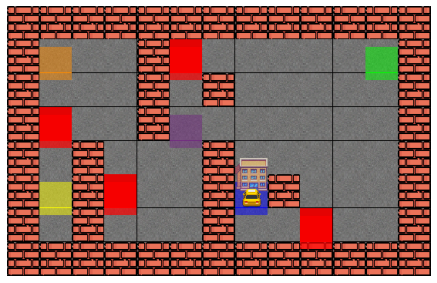

In [2]:
from matplotlib import animation
import matplotlib.pyplot as plt
import gymnasium as gym

"""
Ensure you have imagemagick installed with
sudo apt-get install imagemagick

Open file in CLI with:
xdg-open <filename>
"""

def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
        return [patch]

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

env = gym.make("Taxi-v3_by_Zeynep_Erva", render_mode="rgb_array")

obs, info = env.reset()

frames = []
for t in range(1000):

    frame = env.render()
    frames.append(frame)

    action = env.action_space.sample()

    obs, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        break

env.close()

save_frames_as_gif(frames)


In [33]:
"""Install libraries (outcomment commands by removing # and run cell)"""
#!pip install cmake 'gym[atari]' scipy

'Install libraries (outcomment commands by removing # and run cell)'

In [34]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from time import sleep
from matplotlib import animation
import pandas as pd

In [35]:
def run_animation(experience_buffer):
    """Function to run animation"""
    time_lag = 0.05  # Delay (in s) between frames
    for experience in experience_buffer:
        # Plot frame
        clear_output(wait=True)
        plt.imshow(experience['frame'])
        plt.axis('off')
        plt.show()

        # Print console output
        print(f"Episode: {experience['episode']}/{experience_buffer[-1]['episode']}")
        print(f"Epoch: {experience['epoch']}/{experience_buffer[-1]['epoch']}")
        print(f"State: {experience['state']}")
        print(f"Action: {experience['action']}")
        print(f"Reward: {experience['reward']}")

        # Pauze animation
        sleep(time_lag)

In [36]:
def store_episode_as_gif(experience_buffer, path='./', filename='animation2.gif'):
    """Store episode as gif animation"""
    fps = 5   # Set framew per seconds
    dpi = 30  # Set dots per inch
    interval = 50  # Interval between frames (in ms)

    # Retrieve frames from experience buffer
    frames = []
    for experience in experience_buffer:
        frames.append(experience['frame'])

    # Fix frame size
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # Generate animation
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=interval)

    # Save output as gif
    anim.save(path + filename, writer='imagemagick', fps=fps)

State space: Discrete(1080)
Action space: Discrete(6)
State: 923
Action: 1
Action mask: [0 1 0 0 0 0]
Reward: -1


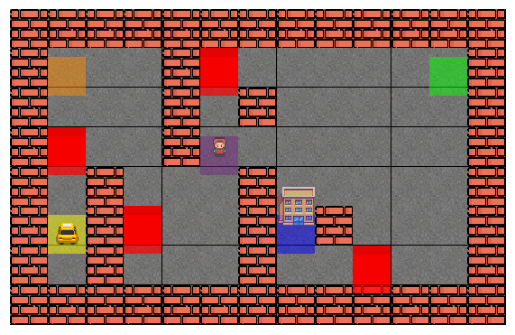

In [37]:

import gymnasium as gym
"""Initialize and validate the environment"""
env = gym.make("Taxi-v3_by_Zeynep_Erva", render_mode="rgb_array").env
state, _ = env.reset()

# Print dimensions of state and action space
print("State space: {}".format(env.observation_space))
print("Action space: {}".format(env.action_space))

action_mask = env.unwrapped.action_mask(state)
valid_actions = np.where(action_mask == 1)[0]

# bunlardan rastgele birini seç
action = np.random.choice(valid_actions)

obs, reward, terminated, truncated, info = env.step(action)

# Print output
print("State: {}".format(state))
print("Action: {}".format(action))
print("Action mask: {}".format(action_mask))
print("Reward: {}".format(reward))

# Render and plot an environment frame
frame = env.render()
plt.imshow(frame)
plt.axis("off")
plt.show()

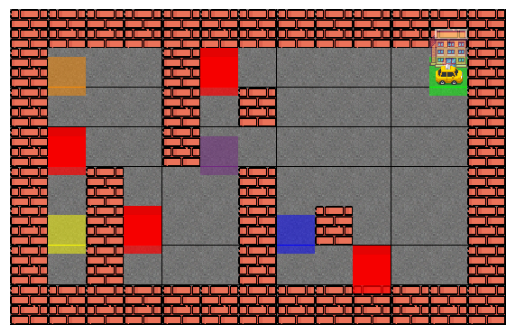

Episode: 1/1
Epoch: 6239/6239
State: 156
Action: 5
Reward: -25545
# epochs: 6240
# failed drop-offs: 1978


In [8]:
"""Simulation with random agent"""
epoch = 0
num_failed_dropoffs = 0
experience_buffer = []
cum_reward = 0

done = False

state, _ = env.reset()

while not done:
    # Sample random action
    action = env.action_space.sample()
    #action = env.action_space.sample(env.action_mask(state))

    state, reward, done, _, _ = env.step(action)
    cum_reward += reward

    # Store experience in dictionary
    experience_buffer.append({
        "frame": env.render(),
        "episode": 1,
        "epoch": epoch,
        "state": state,
        "action": action,
        "reward": cum_reward,
        }
    )

    if reward == -10:
        num_failed_dropoffs += 1

    epoch += 1

# Run animation and print console output
run_animation(experience_buffer)

print("# epochs: {}".format(epoch))
print("# failed drop-offs: {}".format(num_failed_dropoffs))

Episode #: 10000


===Training completed.===



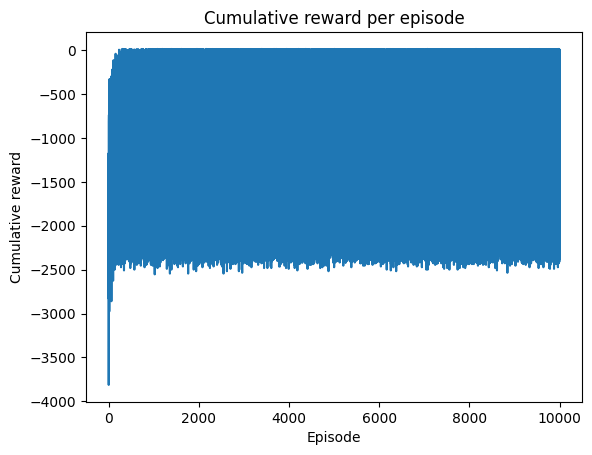

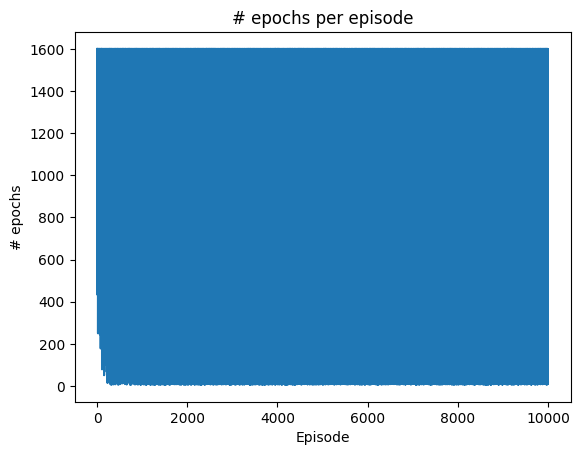

If you want to train the agent, press t; if you want to test policy performance, press e.q


In [51]:
def test_policy_performance():
    """Test policy performance after training"""

    num_epochs = 0
    total_failed_deliveries = 0
    num_episodes = 1
    experience_buffer = []
    store_gif = True

    for episode in range(1, num_episodes+1):
        # Initialize experience buffer

        my_env = env.reset()
        state = my_env[0]
        epoch = 1
        num_failed_deliveries =0
        cum_reward = 0
        done = False

        while not done and epoch<13:
            action = np.argmax(q_table[state])
            state, reward, done, _, _ = env.step(action)
            cum_reward += reward

            if reward == -10:
                num_failed_deliveries += 1

            # Store rendered frame in animation dictionary
            experience_buffer.append({
                'frame': env.render(),
                'episode': episode,
                'epoch': epoch,
                'state': state,
                'action': action,
                'reward': cum_reward
                }
            )

            epoch += 1

        total_failed_deliveries += num_failed_deliveries
        num_epochs += epoch

        if store_gif:
            store_episode_as_gif(experience_buffer)

    # Run animation and print output
    run_animation(experience_buffer)

    # Print final results
    print("\n")
    print(f"Test results after {num_episodes} episodes:")
    print(f"Mean # epochs per episode: {num_epochs / num_episodes}")
    print(f"Mean # failed drop-offs per episode: {total_failed_deliveries / num_episodes}")

def training():

  import numpy as np

  """Training the agent"""
  global q_table
  q_table = np.zeros([env.observation_space.n, env.action_space.n])

  # Hyperparameters
  alpha = 0.1  # Learning rate
  gamma = 1.0  # Discount rate
  epsilon = 0.1  # Exploration rate
  num_episodes = 10000  # Number of episodes

  # Output for plots
  cum_rewards = np.zeros([num_episodes])
  total_epochs = np.zeros([num_episodes])

  # ⭐ Best Model Tracking
  best_reward = -999999
  best_q_table = None

  for episode in range(1, num_episodes+1):
      # Reset environment
      state, info = env.reset()
      epoch = 0
      num_failed_dropoffs = 0
      done = False
      cum_reward = 0

      while not done and epoch<1600:

          if random.uniform(0, 1) < epsilon:
              "Basic exploration [~0.47m]"
              action = env.action_space.sample() # Sample random action (exploration)

              "Exploration with action mask [~1.52m]"
            # action = env.action_space.sample(env.action_mask(state)) "Exploration with action mask"
          else:
              "Exploitation with action mask [~1m52s]"
            # action_mask = np.where(info["action_mask"]==1,0,1) # invert
            # masked_q_values = np.ma.array(q_table[state], mask=action_mask, dtype=np.float32)
            # action = np.ma.argmax(masked_q_values, axis=0)

              "Exploitation with random tie breaker [~1m19s]"
            #  action = np.random.choice(np.flatnonzero(q_table[state] == q_table[state].max()))

              "Basic exploitation [~47s]"
              action = np.argmax(q_table[state]) # Select best known action (exploitation)

          next_state, reward, done, _ , info = env.step(action)

          cum_reward += reward

          old_q_value = q_table[state, action]
          next_max = np.max(q_table[next_state])

          new_q_value = (1 - alpha) * old_q_value + alpha * (reward + gamma * next_max)

          q_table[state, action] = new_q_value

          if reward == -10:
              num_failed_dropoffs += 1

          state = next_state
          epoch += 1
          total_epochs[episode-1] = epoch
          cum_rewards[episode-1] = cum_reward

          # ⭐ Best Model Check
          if cum_reward > best_reward:
            best_reward = cum_reward
            best_q_table = q_table.copy()

      if episode % 100 == 0:
          clear_output(wait=True)
          print(f"Episode #: {episode}")
      """if episode % 300 == 0:
            test_policy_performance()"""




  print("\n")
  print("===Training completed.===\n")

  # Plot reward convergence
  plt.title("Cumulative reward per episode")
  plt.xlabel("Episode")
  plt.ylabel("Cumulative reward")
  plt.plot(cum_rewards)
  plt.show()

  # Plot epoch convergence
  plt.title("# epochs per episode")
  plt.xlabel("Episode")
  plt.ylabel("# epochs")
  plt.plot(total_epochs)
  plt.show()

  import pandas as pd
  import numpy as np

  # q_table: önceden oluşturulmuş NumPy array
  # Örnek: q_table.shape = (1080, 6)  # 1080 durum, 6 aksiyon


  df_best = pd.DataFrame(
      best_q_table,
      columns=[f"action_{i}" for i in range(best_q_table.shape[1])]
  )
  df_best.insert(0, "state", range(best_q_table.shape[0]))
  df_best.to_csv("best_model_q_table.csv", index=False)
  # --- NORMAL Q TABLE KAYDETME ---
  df = pd.DataFrame(
      q_table,
      columns=[f"action_{i}" for i in range(q_table.shape[1])]
  )
  df.insert(0, "state", range(q_table.shape[0]))
  df.to_csv("q_table.csv", index=False)



while True:
  method_argument=input("If you want to train the agent, press t; if you want to test policy performance, press e.")
  if method_argument=="t":
    training()
  elif method_argument=="e":
    test_policy_performance()
  else:
    break